## Benchmarking 4

The stability of the QR decomposition algorithm is crucial. Because both the Indirect and Cholesky TSQR implementations rely on matrix inversion to compute the matrix Q, they can produce a Q matrix that is not exactly orthogonal, especially if the original matrix A is ill-conditioned.

However, if a cheap method for correcting this orthogonal error exists, the faster execution time of the Indirect and Cholesky methods could make them a preferable choice over the Direct method. Benson et al. (2013) successfully implemented an iterative correction protocol to reduce the orthogonal error of the matrix Q, which arises from the high condition number of A.

In [1]:
from dask.distributed import Client, wait
from dask import delayed
import dask.array as da

from functions import cholesky_tsqr, indirect_tsqr, direct_tsqr
import numpy as np

import gc

The condition number of a matrix with respect to the $L^2$-norm is defined as the ratio of its largest to smallest singular value:
$$\kappa(A)=\frac{\sigma_{\text{max}}(A)}{\sigma_{\text{min}}(A)}$$
By prescribing singular values and applying the singular value decomposition (SVD), we can construct an ill-conditioned matrix.

In [2]:
def generate_ill_conditioned(shape : tuple, cond : float) -> np.ndarray:
    ''' 
    Generate an ill-conditioned matrix of given shape and condition number.
    
    Parameters:
    -----------
    shape : tuple
        Shape of the matrix to be generated (m, n).
    cond : float
        Condition number of the matrix.

    Returns:
    --------
    np.ndarray
        An ill-conditioned matrix of shape (m, n) with the specified condition number.
    '''
    n, m = shape
    k = min(m, n)

    s = np.linspace(1, 1/cond, k)

    U, _ = np.linalg.qr(np.random.randn(m,m))
    V, _ = np.linalg.qr(np.random.randn(n,n))

    S = np.zeros((m,n))
    np.fill_diagonal(S, s)
    return U @ S @ V

#### **System specifications**
- CPU: Intel Core i7-14700K (20 Core, 28 Threads - Turbo Frequency 5.6 GHz)
- RAM: 32 GB (DDR5)

In [ ]:
# Initialize Dask client with 3 workers (LOCAL SETUP)
N_WORKERS = 3
THREADS_PER_WORKER = 1
MEMORY_PER_WORKER = "4GB"
client = Client(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    memory_limit=MEMORY_PER_WORKER,
)

print(f"DASK Client with {N_WORKERS} workers ({THREADS_PER_WORKER} threads, {MEMORY_PER_WORKER} memory)")
print("Dashboard:", client.dashboard_link)

DASK Client with 3 workers (1 threads, 4GB memory)
Dashboard: http://127.0.0.1:8787/status


In [4]:
n, m = 4, 1_000   # Fixed matrix shape
cond = np.logspace(0, 8, 10, base=10.0)    # Condition numbers to test

results = {
    "Cholesky": (cholesky_tsqr, []),
    "Indirect": (indirect_tsqr, []),
    "Direct": (direct_tsqr, []),
}

for c in cond:
    print(f"Condition number: {c:.1e}")
    # Creation of a random ill-conditioned array inside the
    # workers, subdivided evenly in N_WORKERS chunks.
    A = generate_ill_conditioned((n, m), c)
    chunks = [m // N_WORKERS for _ in range(N_WORKERS-1)]
    chunks.append(m - sum(chunks))
    X_da = da.from_array(A, chunks=(chunks, n))
    X_da.persist()

    for name, (algorithm, _) in results.items():
        print(f"  {name}", end=" ")
        Q, _ = algorithm(X_da)
        Qt = delayed(np.transpose)(Q)
        _tmp = delayed(np.linalg.matmul)(Qt, Q)
        _tmp = _tmp.compute()   # _tmp is now small (n x n)
        wait(_tmp)
        
        # Compute the orthogonality error
        orthogonality = np.linalg.norm(_tmp - np.eye(n))
        print(f"({orthogonality:.1e})")
        results[name][1].append(orthogonality)
        
        # Clean memory from previous computations
        client.cancel(Q)
    
    print()
    client.cancel(X_da)
    gc.collect()
    client.run(gc.collect)


Condition number: 1.0e+00
  Cholesky (4.2e-16)
  Indirect (4.5e-16)
  Direct (8.6e-16)

Condition number: 7.7e+00
  Cholesky (1.6e+01)
  Indirect (1.0e-15)
  Direct (5.0e-16)

Condition number: 6.0e+01
  Cholesky (1.3e+03)
  Indirect (7.6e-15)
  Direct (3.6e-16)

Condition number: 4.6e+02
  Cholesky (5.5e+04)
  Indirect (4.2e-14)
  Direct (6.0e-16)

Condition number: 3.6e+03
  Cholesky (2.9e+06)
  Indirect (9.2e-14)
  Direct (3.6e-16)

Condition number: 2.8e+04
  Cholesky (1.5e+08)
  Indirect (8.8e-12)
  Direct (7.1e-16)

Condition number: 2.2e+05
  Cholesky (2.0e+10)
  Indirect (1.9e-11)
  Direct (3.2e-16)

Condition number: 1.7e+06
  Cholesky (7.6e+11)
  Indirect (3.4e-10)
  Direct (3.2e-16)

Condition number: 1.3e+07
  Cholesky (1.2e+14)
  Indirect (1.1e-09)
  Direct (1.1e-15)

Condition number: 1.0e+08
  Cholesky (9.8e+15)
  Indirect (1.4e-08)
  Direct (5.6e-16)



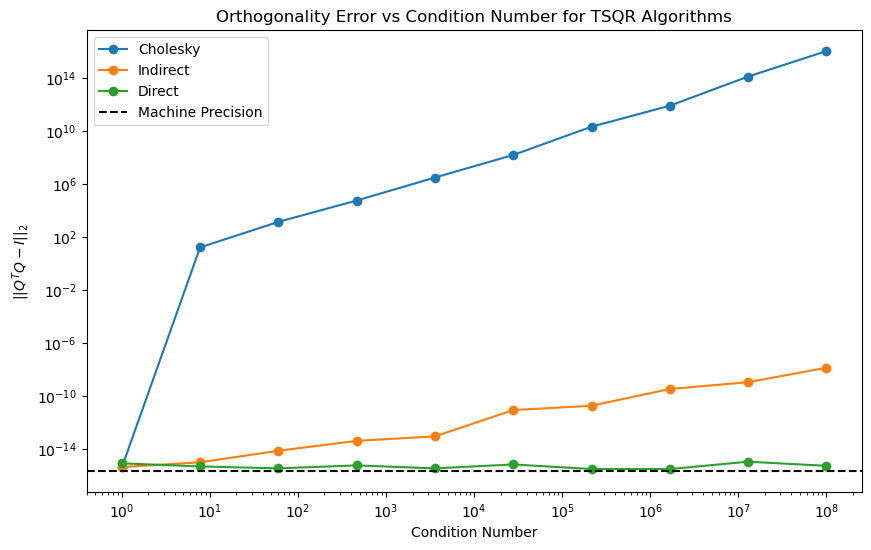

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, (_, orthogonalities) in results.items():
    plt.plot(cond, orthogonalities, marker='o', label=name)
plt.axhline(y=np.finfo(float).eps, color='k', linestyle='--', label='Machine Precision')
plt.xlabel('Condition Number')
plt.ylabel('$||Q^T Q - I||_2$')
plt.title('Orthogonality Error vs Condition Number for TSQR Algorithms')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## Iterative correction
In the ill-conditioned regime, such as when using Indirect or Cholesky TSQR decomposition, a single iterative refinement step is often sufficient to improve the stability of the algorithm (Benson et al.). In both the Cholesky and Indirect approaches, we compute $Q=AR^{-1}$, but if $A$ is ill-conditioned, the resulting $Q$ may not be exactly orthogonal. Let $Q_0$ denote our initial approximation of $Q$, and define the orthogonality error:
$$E=1-Q_0^T Q_0$$
We can write the exact orthogonal $Q$ as $Q=Q_0+\Delta Q$. Because $Q^TQ=1$, and expanding $Q=Q_0+\Delta Q$ from the orthogonality condition $Q^T Q=1$ to first order in $\Delta Q_0$, we get $E\simeq Q_0^T \Delta Q+\Delta Q^T Q_0$. Assuming the deviation $\Delta Q$ is linear in $Q_0$ (i.e. $\Delta Q=Q_0 X$), and using $Q_0^TQ_0\approx 1$, we obtain $E\approx X+X^T$. Since $E$ is symmetric, a solution is $X=E/2$, yelding:
$$Q\approx Q_0+\frac{1}{2}Q_0E=Q_0\left(1+\frac{1}{2}E\right)$$
From our analysis, in matrices with high condition number, the Cholesky algorithm with a step of iterative correction alone performs poorly, whereas the Indirect method achieves results comparable to the Direct. To further improve the Cholesky method, we can apply multiple iterative correction steps and introduce an adaptive step size $\alpha$. 
$$Q\leftarrow Q+\alpha QE$$

In [ ]:
instable_algorithm = {
    "Cholesky IR": (cholesky_tsqr, []),
    "Indirect IR": (indirect_tsqr, []),
}


def iterative_refinement(Q : np.ndarray, n_iter : int = 1) -> np.ndarray:
    ''' 
    Perform iterative refinement to improve the orthogonality of matrix Q.

    Parameters:
    ---------
    Q : np.ndarray
        Initial near-orthogonal matrix to be refined.
    n_iter : int
        Number of iterative refinement steps to perform.

    Returns:
    --------
    np.ndarray
        Refined orthogonal matrix.
    '''
    for _ in range(n_iter):
        E = np.eye(n) - Q.T @ Q
        error_norm = np.linalg.norm(E)
        # Adaptive step size
        alpha = min(0.5, 1.0 / (1.0 + error_norm))
        Q = Q + alpha * Q @ E
    return Q


for c in cond:
    print(f"Condition number: {c:.1e}")
    # Creation of a random ill-conditioned array inside the
    # workers, subdivided evenly in N_WORKERS chunks.
    A = generate_ill_conditioned((n, m), c)
    chunks = [m // N_WORKERS for _ in range(N_WORKERS-1)]
    chunks.append(m - sum(chunks))
    X_da = da.from_array(A, chunks=(chunks, n))
    X_da.persist()

    for name, (algorithm, _) in instable_algorithm.items():
        print(f"  {name}", end=" ") 
        Q, R = algorithm(X_da)
        Q = Q.compute()
        
        # Apply iterative refinement.
        # For Cholesky, n_iter=60 is needed to reach machine precision.
        Q = iterative_refinement(Q, n_iter=60)

        # Compute the orthogonality error
        orthogonality = np.linalg.norm(Q.T @ Q - np.eye(n))
        print(f"({orthogonality:.1e})")
        instable_algorithm[name][1].append(orthogonality)
        
        # Clean memory from previous computations
        client.cancel(Q)
    
    print()
    client.cancel(X_da)
    gc.collect()
    client.run(gc.collect)

Condition number: 1.0e+00
  Cholesky IR (3.5e-18)
  Indirect IR (5.6e-18)

Condition number: 7.7e+00
  Cholesky IR (2.2e-16)
  Indirect IR (1.1e-16)

Condition number: 6.0e+01
  Cholesky IR (2.2e-16)
  Indirect IR (2.2e-16)

Condition number: 4.6e+02
  Cholesky IR (5.7e-18)
  Indirect IR (2.2e-16)

Condition number: 3.6e+03
  Cholesky IR (6.4e-18)
  Indirect IR (4.4e-16)

Condition number: 2.8e+04
  Cholesky IR (1.1e-16)
  Indirect IR (4.1e-18)

Condition number: 2.2e+05
  Cholesky IR (2.5e-16)
  Indirect IR (2.2e-16)

Condition number: 1.7e+06
  Cholesky IR (1.1e-16)
  Indirect IR (3.3e-18)

Condition number: 1.3e+07
  Cholesky IR (1.6e-16)
  Indirect IR (5.6e-18)

Condition number: 1.0e+08
  Cholesky IR (1.1e-16)
  Indirect IR (6.0e-18)



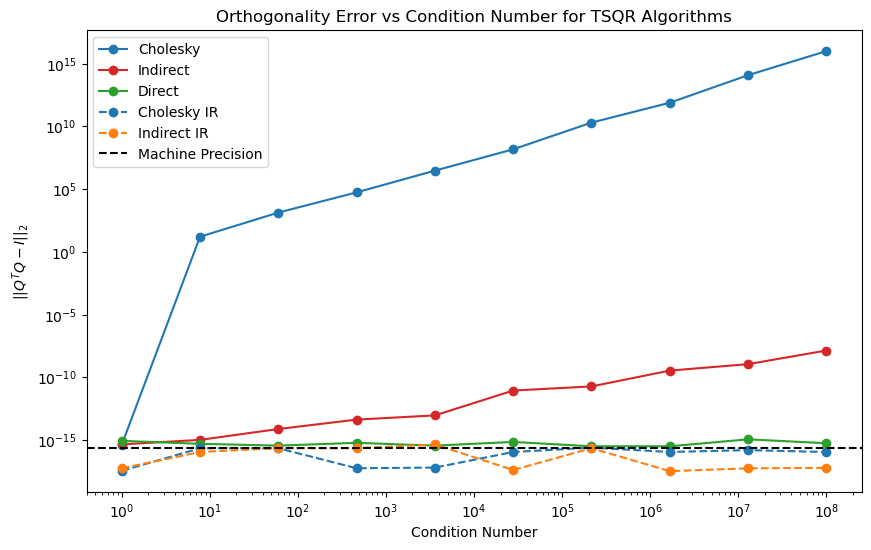

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt

palette = {
    "Cholesky": "tab:blue",
    "Indirect": "tab:red",
    "Direct": "tab:green",
}


plt.figure(figsize=(10, 6))
for name, (_, orthogonalities) in results.items():
    plt.plot(cond, orthogonalities, marker='o', label=name, color=palette[name])
for name, (_, orthogonalities) in instable_algorithm.items():
    plt.plot(cond, orthogonalities, marker='o', label=name, linestyle='--')
plt.axhline(y=np.finfo(float).eps, color='k', linestyle='--', label='Machine Precision')
plt.xlabel('Condition Number')
plt.ylabel('$||Q^T Q - I||_2$')
plt.title('Orthogonality Error vs Condition Number for TSQR Algorithms')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [8]:
client.close()